# **K-Nearest Neighbors Regression to predict banana fruit ripeness**

## Prerequisite

### Import Library

In [12]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

### Load Data

In [2]:
# GET data from REST API
url = "https://banana-ripeness-predictor.vercel.app/api/training"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    display(df.head())
else:
    print("Failed load data:", response.status_code)

,id,r,g,b,timestamp,ripeness,tvoc,nextPhase
0,2fF8hHgm196LlVv1tMZQ,96,88,45,2025-09-23T16:54:39.806+07:00,raw,80,5.0
1,5IraNr1LCXt1VlWWwGqe,96,88,45,2025-09-19T14:45:00.000Z,raw,100,4.0
2,6WTCGhob7hdrQveQs9Gs,96,88,45,2025-09-25T16:14:27.681+07:00,ripe,220,1.0
3,8NfbnTOUg4kbwWZ2p8dB,96,88,45,2025-09-25T16:14:59.872+07:00,ripe,240,0.5
4,KlCeQNfXsSM4tsqZ3PA9,96,88,45,2025-09-25T16:15:01.484+07:00,spoiled,260,0.0


### Preprocessing

In [3]:
# Select relevant attributes
df = df[["tvoc", "ripeness", "nextPhase"]]

# Imputation if there are missing values
df = df.fillna(df.mean(numeric_only=True))

# Encoding categorical column 'ripeness'
df = pd.get_dummies(df, columns=["ripeness"])

# Normalisasi tvoc
df["tvoc"] = (df["tvoc"] - df["tvoc"].min()) / (df["tvoc"].max() - df["tvoc"].min())

display(df.head())

,tvoc,nextPhase,ripeness_raw,ripeness_ripe,ripeness_spoiled
0,0.000000,5.0,True,False,False
1,0.111111,4.0,True,False,False
2,0.777778,1.0,False,True,False
3,0.888889,0.5,False,True,False
4,1.000000,0.0,False,False,True


### Split Data

In [4]:
# X = features (tvoc + ripeness encoded), y = target (nextPhase)
X = df.drop("nextPhase", axis=1).values
y = df["nextPhase"].values

# Define function to split data
def train_test_split(X, y, test_size=0.2, random_state=None):
    n = len(X)
    indices = np.arange(n)
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(indices)
    
    split = int(n * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions of train data:", X_train.shape)
print("Dimensions of test data:", X_test.shape)

Dimensions of train data: (8, 4)
Dimensions of test data: (2, 4)


## Tuning

### Definition of KNN Core Functions

In [5]:
# KNN (regression) core functions
def euclidean_distance(x1, x2):
    """Calculate the Euclidean distance between two vectors"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def predict_knn(x_new, X_train, y_train, k):
    """Prediction of 1 new data with KNN regression"""
    distances = [euclidean_distance(x_new, x) for x in X_train]
    k_idx = np.argsort(distances)[:k]
    return np.mean(y_train[k_idx])   # regresi → rata-rata target tetangga

def evaluate_knn(X_val, y_val, X_train, y_train, k):
    """KNN evaluation for 1 value of k"""
    preds = [predict_knn(x, X_train, y_train, k) for x in X_val]
    
    mae = np.mean(np.abs(y_val - preds))
    rmse = np.sqrt(np.mean((y_val - preds) ** 2))
    ss_res = np.sum((y_val - preds) ** 2)
    ss_tot = np.sum((y_val - np.mean(y_val)) ** 2)
    r2 = 1 - ss_res/ss_tot
    
    return {"k": k, "MAE": mae, "RMSE": rmse, "R2": r2}

### Loop Tuning k

In [6]:
# Test the k value from 1 to 10
k_values = range(1, 11)
tuning_results = []

for k in k_values:
    result = evaluate_knn(X_test, y_test, X_train, y_train, k)
    tuning_results.append(result)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(tuning_results)
results_df

,k,MAE,RMSE,R2
0,1,0.750000,0.790569,-0.111111
1,2,0.500000,0.707107,0.111111
2,3,1.083333,1.160699,-1.395062
3,4,1.125000,1.131923,-1.277778
4,5,1.050000,1.060660,-1.000000
5,6,1.083333,1.086534,-1.098765
6,7,1.107143,1.174777,-1.453515
7,8,1.125000,1.352082,-2.250000
8,9,1.125000,1.352082,-2.250000
9,10,1.125000,1.352082,-2.250000


### Tuning Results Visualization

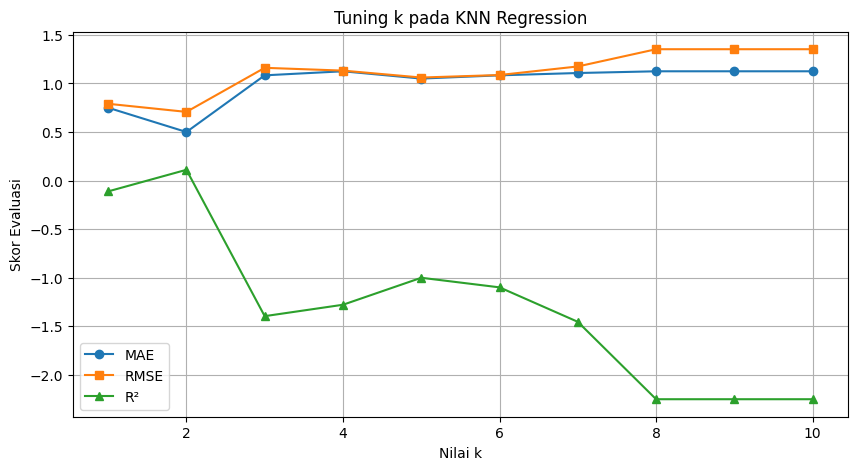

In [ ]:
# Visualization of the performance of each k
plt.figure(figsize=(10, 5))
plt.plot(results_df["k"], results_df["MAE"], label="MAE", marker="o")
plt.plot(results_df["k"], results_df["RMSE"], label="RMSE", marker="s")
plt.plot(results_df["k"], results_df["R2"], label="R²", marker="^")
plt.xlabel("k Value")
plt.ylabel("Evaluation Score")
plt.title("Tuning k on KNN Regression")
plt.legend()
plt.grid(True)
plt.show()

### Select k Optimal

In [ ]:
# Choose k with the smallest RMSE
best_row = results_df.loc[results_df["RMSE"].idxmin()]
best_k = int(best_row["k"])

print("k optimal:", best_k)
print("Best evaluation score:")
print(best_row)

k optimal: 2
Skor evaluasi terbaik:
k       2.000000
MAE     0.500000
RMSE    0.707107
R2      0.111111
Name: 1, dtype: float64


### Final Evaluation

In [ ]:
# Finalization of the KNN model with the best k
model_config = {
    "k": best_k,
    "X_train": X_train.tolist(),
    "y_train": y_train.tolist()
}

Model final siap digunakan.


## Deployment

### Save Config File

In [14]:
def save_model_to_json(model_config, filename="knn_model_config.json"):
    """Save the KNN model configuration to a JSON file."""
    try:
        with open(filename, "w") as f:
            json.dump(model_config, f, indent=2)
        print(f"Model configuration successfully saved to '{filename}'")
    except Exception as e:
        print("Failed to save model:", e)

# Save model
save_model_to_json(model_config)

Model configuration successfully saved to 'knn_model_config.json'
